In [1]:
%matplotlib inline

from lib import plot
from lib.classification_report import ClassificationReport
from lib.neural_networks import NeuralNetwork
from lib.dataset import get_lfw_dataset
from lib.pca import PCA
from lib.plot import plot_eigenface
from lib.util import scale, prepare_labels

import logging

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from numpy import copy, argmax, mean, bincount

import os

import cPickle as pickle

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

import sys

from time import time

/Users/tranl01/anaconda/envs/learn/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Show logs during runtime 
# (does not work with ipython notebook, 
#but for normal python interpreter)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

# Dataset
- Get "Labeled Faces in the Wild" (LFW) people dataset
- Data will be downloaded, if not available locally, and loaded as numpy array
- Print out information about dataset

In [3]:
lfw = get_lfw_dataset(min_face=70)
X = lfw.X
y = lfw.y
n_samples = lfw.n_samples
h = lfw.h
w = lfw.w
lfw.summarize()

Size of LFW dataset:
 - Number of samples: 1288
 - Number of features: 1850
 - Number of classes: 7
 - Minimum number of faces per person: 70


In [4]:
# Splitting data set in training set and test set
X_train, X_test, y_train, y_test = lfw.load_train_test_split()

# Eigenface algorithm

Explained variance: 0.913839


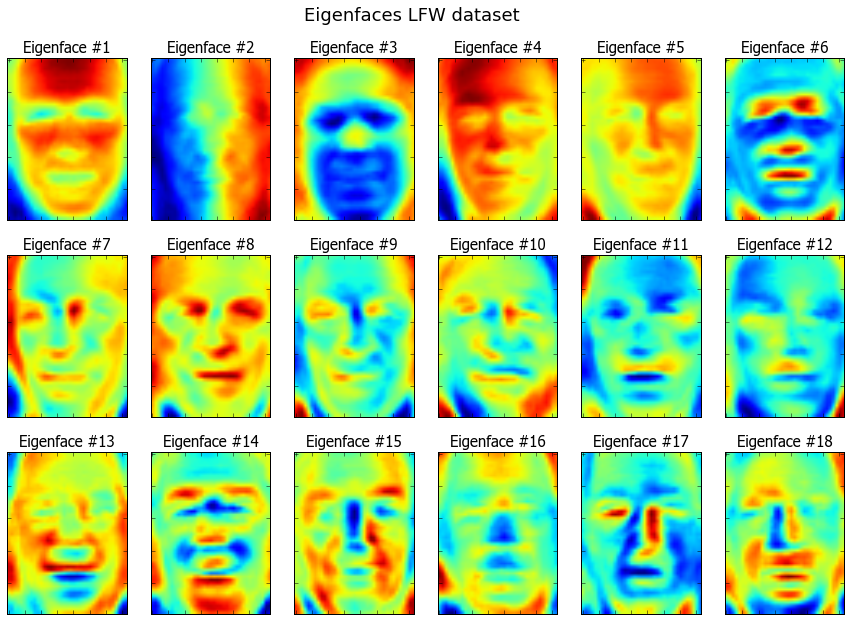

In [5]:
# Example of PCA
pca = PCA(X, n_components=75)
print 'Explained variance: %s' % pca.get_explained_variance_ratio().sum()
components = pca.get_components()
mu = pca.get_mu()
Eigenfaces = []
for i in range(min(len(X), 18)):
    e = components[i,:].reshape(h, w)
    Eigenfaces.append(scale(e,0,255))
plot_eigenface(
    title="Eigenfaces LFW dataset", images=Eigenfaces, rows=3, cols=6,
    sptitle="Eigenface", colormap=cm.jet, filename=None
)

In [7]:
# Use training set for hyperparameter estimation with 10fold CV
n_folds = 10
X_CV = copy(X_train)
y_CV = copy(y_train)
n_cv = X_CV.shape[0]
kfold = KFold(n_cv, n_folds=n_folds)

In [8]:
tmp_folder = "tmp/"
results_file = "svm_f1_score_results.p"
kfold_file = "%s_kfolds_{min_face}.p" % n_folds
tmp_result_file = "svm_f1_{C}_{gamma}_{min_face}_result_{n_comps}.p"

# Train a SVM

In [9]:
n_components = 75
kernel = "rbf"
param_grid = {
    'C': [0.1, 1, 10, 50, 100, 500, 1000, 3000],
    'gamma': [0.0001, 0.0005, 0.001, 0.003, 0.005,
              0.01, 0.05, 0.1, 0.5, 1.0, 5.0] 
}

print("Performing grid search for best (C, gamma)"
      "-parameter based on 10fold-CV.")
sys.stdout.flush()

f1_results = {c: {} for c in param_grid['C']}
for c in param_grid['C']:
    for gamma in param_grid['gamma']:
        f1_results[c][gamma] = []

t0 = time()
for c in param_grid['C']:
    for gamma in param_grid['gamma']:
        tmp_file = os.path.join(
            tmp_folder, tmp_result_file.format(
                C=c, gamma=gamma, min_face=lfw.min_face, n_comps=n_components))
        for train_index, test_index in kfold:
            X_CV_train, X_CV_test = X_CV[train_index], X_CV[test_index]
            y_CV_train, y_CV_test = y_CV[train_index], y_CV[test_index]
            pca = PCA(X_CV_train, n_components=n_components)
            pca_train = pca.transform(X_CV_train)
            pca_test = pca.transform(X_CV_test) 
            clf = SVC(
                kernel=kernel, gamma=gamma, C=c, class_weight='balanced')
            clf.fit(pca_train, y_CV_train)
            y_pred = clf.predict(pca_test)
            report = ClassificationReport(
                y_CV_test, y_pred, target_names=lfw.label_names)
            f1_results[c][gamma].append(report.get_avg_f1_score())
        pickle.dump(
            {c: {gamma: f1_results[c][gamma]}}, open(tmp_file, 'w+'))
        print(
            "Avg. F1 = %0.3f (C=%s, gamma=%s)" % (
                sum(f1_results[c][gamma])/10.0, 
                c, gamma
            )
        )
        sys.stdout.flush()
pickle.dump(f1_results, open(results_file, 'w+'))
print("done in %0.3fs" % (time() - t0))

best_parameter = {"f1": 0.00, "gamma": 0.00, "C": 0.00}
for c, d in f1_results.iteritems():
    for gamma, f1_list in d.iteritems():
        if sum(f1_list)/10.0 > best_parameter['f1']:
            best_parameter['f1'] = sum(f1_list)/10.0
            best_parameter['gamma'] = gamma
            best_parameter['C'] = c
print "Best parameter for SVM (f1={f1}): C={C}, gamma={g}".format(
    f1=best_parameter['f1'], C=best_parameter['C'], g=best_parameter['gamma']
)

Performing grid search for best (C, gamma)-parameter based on 10fold-CV.
Avg. F1 = 0.052 (C=0.1, gamma=0.0001)
Avg. F1 = 0.052 (C=0.1, gamma=0.0005)
Avg. F1 = 0.052 (C=0.1, gamma=0.001)
Avg. F1 = 0.059 (C=0.1, gamma=0.003)
Avg. F1 = 0.130 (C=0.1, gamma=0.005)
Avg. F1 = 0.222 (C=0.1, gamma=0.01)
Avg. F1 = 0.052 (C=0.1, gamma=0.05)
Avg. F1 = 0.052 (C=0.1, gamma=0.1)
Avg. F1 = 0.052 (C=0.1, gamma=0.5)
Avg. F1 = 0.052 (C=0.1, gamma=1.0)
Avg. F1 = 0.052 (C=0.1, gamma=5.0)
Avg. F1 = 0.033 (C=1, gamma=0.0001)
Avg. F1 = 0.704 (C=1, gamma=0.0005)
Avg. F1 = 0.791 (C=1, gamma=0.001)
Avg. F1 = 0.796 (C=1, gamma=0.003)
Avg. F1 = 0.809 (C=1, gamma=0.005)
Avg. F1 = 0.825 (C=1, gamma=0.01)
Avg. F1 = 0.432 (C=1, gamma=0.05)
Avg. F1 = 0.248 (C=1, gamma=0.1)
Avg. F1 = 0.099 (C=1, gamma=0.5)
Avg. F1 = 0.099 (C=1, gamma=1.0)
Avg. F1 = 0.099 (C=1, gamma=5.0)
Avg. F1 = 0.789 (C=10, gamma=0.0001)
Avg. F1 = 0.777 (C=10, gamma=0.0005)
Avg. F1 = 0.792 (C=10, gamma=0.001)
Avg. F1 = 0.811 (C=10, gamma=0.003)
Avg. 

/Users/tranl01/anaconda/envs/learn/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average F1-score: 0.89
Accuracy: 89.13%
Error rate: 10.87% (35/322)
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.71      0.83        14
     Colin Powell       0.89      0.92      0.91        53
  Donald Rumsfeld       0.86      0.86      0.86        29
    George W Bush       0.93      0.97      0.95       143
Gerhard Schroeder       0.78      0.75      0.77        24
      Hugo Chavez       0.73      0.57      0.64        14
       Tony Blair       0.84      0.84      0.84        45

      avg / total       0.89      0.89      0.89       322



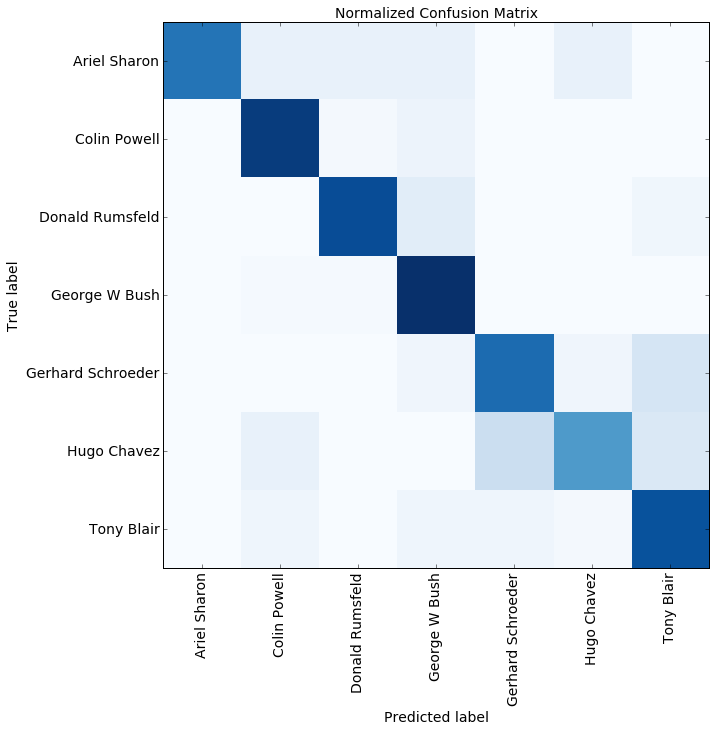

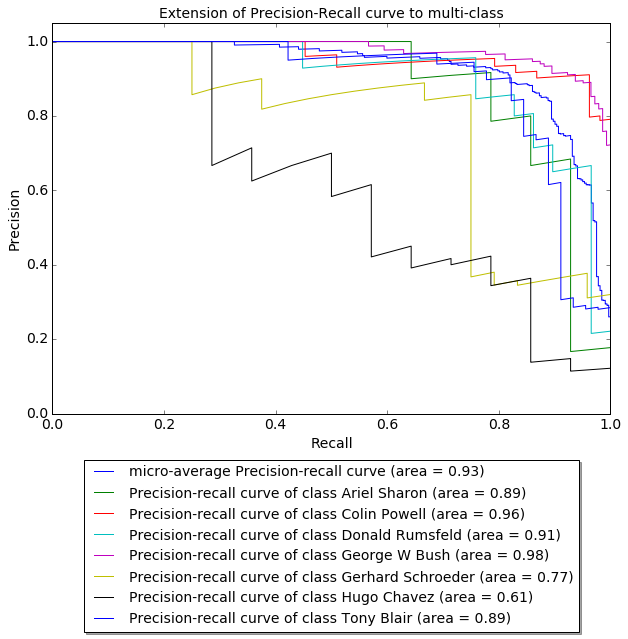

In [10]:
# Train test set with best parameter
clf = OneVsRestClassifier(SVC(
    kernel=kernel, gamma=best_parameter['gamma'], 
    C=best_parameter['C'], class_weight='balanced'
))
pca = PCA(X_CV, n_components=n_components)
pca_CV = pca.transform(X_CV)
pca_test = pca.transform(X_test)
clf.fit(pca_CV, y_CV)
y_pred = clf.predict(pca_test)
y_score = clf.decision_function(pca_test)
y_test_matrix = prepare_labels(y_test, lfw.n_classes)

# Classfication report
report = ClassificationReport(y_test, y_pred, target_names=lfw.label_names)
print 'Average F1-score: %0.2f' % report.get_avg_f1_score()
print 'Accuracy: %0.2f%%' % (accuracy_score(y_test, y_pred)*100)
print 'Error rate: %0.2f%% (%s/%s)' % (
    (y_test != y_pred).sum()/float(len(y_pred)) * 100,
    (y_test != y_pred).sum(),
    len(y_pred)
)
print report.report

# Confusion matrix
plot.plot_normalized_confusion_matrix(
    y_test, y_pred, lfw.n_classes, lfw.label_names, figsize=(15,10),
    filename=os.path.join(os.getcwd(), 'data', 'confusion_matrix_70_lfw.png')
)

# Precision recall curves for each class
plot.plot_precision_recall_curves(
    y_test, y_score, lfw.n_classes, label_names=lfw.label_names,
    filename=os.path.join(os.getcwd(), 'data', 'precision_recall_70_lfw.png')
)
plt.show()

# Train a Neural Network

In [5]:
# Splitting data set in training set and test set
X_train, X_test, y_train, y_test = lfw.load_train_test_split()

n_components = 75
pca = PCA(X_train, n_components=n_components)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test) 

# Layer's sizes
x_size = pca_train.shape[1]     # Number of input nodes
h_size = 40                     # Number of hidden nodes
y_size = lfw.n_classes          # Number of outcomes
weights = float(lfw.n_samples) / (lfw.n_classes * bincount(y_train))
nn = NeuralNetwork(x_size, h_size, y_size, batch=20,
                   weighted=True, weights=weights)
results = nn.evaluate_learning_rate(
    pca_train, pca_test, y_train, y_test, lfw.n_classes,
    stdout=False, label_names=lfw.label_names,
    learning_rate=[0.3]
)

Learning rate = 0.3, train accuracy = 69.77%, test accuracy = 70.50%, test f1 = 67.00%


/Users/tranl01/anaconda/envs/learn/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


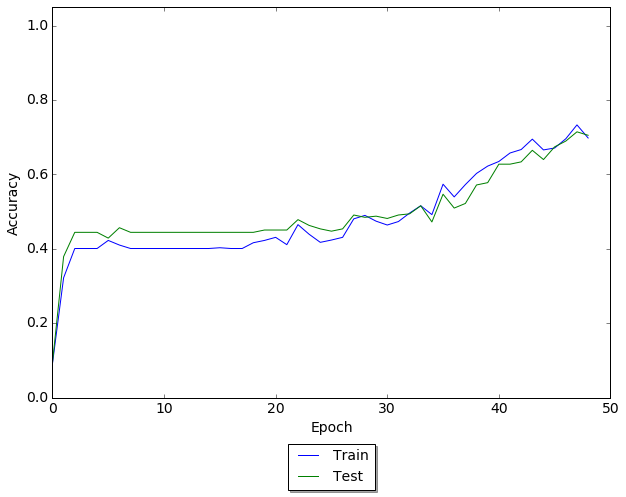

In [6]:
plot.plot_epochs(results['epoch'], results['train_accuracy'], results['test_accuracy'])